In [ ]:
import tifffile
from skimage import io
from PIL import Image
import cv2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F

from glob import glob
import os.path as osp
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH='/content/drive/MyDrive/Dataset_BUSI_with_GT'
IMAGES_PATH = osp.join(BASE_PATH, 'images')
LABELS_PATH = osp.join(BASE_PATH, 'masks')

In [ ]:
imgs_paths = glob(osp.join(IMAGES_PATH,'*jpg'))


In [ ]:
print(len(imgs_paths))

2592


In [ ]:
masks_paths = [osp.join(LABELS_PATH, i.rsplit("/",1)[-1].split("_ccd")[0]) for i in imgs_paths]



In [ ]:
print(len(masks_paths))

2592


In [ ]:
print(f"Number of images found: {len(imgs_paths)}")
print(f"Number of masks found: {len(masks_paths)}")

Number of images found: 2592
Number of masks found: 2592


In [ ]:
def get_tiff_image(path, normalized=True, resize=(512, 512)):
    image = io.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, resize)
    if normalized:
        return (image / 255.0).astype(np.float32)
    return image.astype(np.float32)

In [ ]:
def get_image(path, normalize=True, resize=(512, 512)):
    image = io.imread(path)
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, resize)
    if normalize:
        return (image / 255.0).astype(np.float32)
    return image.astype(np.float32)

In [ ]:
class BCDataset(torch.utils.data.Dataset):

    def __init__(self, img_mask_tuples):
        self.img_mask_tuples = img_mask_tuples

    def __len__(self,):
        return len(self.img_mask_tuples)

    def __getitem__(self, idx):

        img_path, mask_path = self.img_mask_tuples[idx]

        image = get_tiff_image(img_path)
        mask = get_tiff_image(mask_path, normalized=False)
        mask[mask > 0] = 1

        return image,mask

In [ ]:
img_mask_tuples = list(zip(imgs_paths, masks_paths))

random.shuffle(img_mask_tuples)

train_tuples, test_tuples = train_test_split(img_mask_tuples)

In [ ]:
train_dataset = BCDataset(train_tuples)
test_dataset = BCDataset(test_tuples)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)


In [ ]:
import torch.nn.functional as F
class DoubleConv(nn.Module):


    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):


    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):


    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()


        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=3, n_classes=1)
model.to(device);

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def dice_loss(inputs, target):
    inputs = torch.sigmoid(inputs)
    smooth = 1.
    iflat = inputs.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    loss = 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return loss

In [ ]:
import torch
from tqdm import tqdm
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
best_accuracy = 0.0


def save_checkpoint(model, optimizer, epoch, loss, accuracy, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}_acc_{accuracy:.4f}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')


def load_checkpoint(model, optimizer, checkpoint_dir, device):
    latest_checkpoint = max([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')], key=lambda x: int(x.split('_')[2]), default=None)
    if latest_checkpoint:
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        accuracy = checkpoint['accuracy']
        print(f'Resuming from checkpoint {checkpoint_path}, epoch {start_epoch} with accuracy {accuracy:.4f}')
        return start_epoch, loss, accuracy
    return 0, None, 0.0


def calculate_accuracy(output, labels):
    preds = torch.sigmoid(output) > 0.5
    correct = preds.eq(labels).sum().item()
    total = labels.numel()
    accuracy = correct / total
    return accuracy


start_epoch, _, best_accuracy = load_checkpoint(model, optimizer, checkpoint_dir, device)


In [ ]:
for epoch in range(start_epoch, 10):
    epoch_loss = 0
    total_accuracy = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/10', leave=False)):
        images = images.to(device)
        labels = labels.to(device)


        images = images.permute(0, 3, 2, 1).float()
        labels = labels.permute(0, 3, 2, 1).float()
        labels = labels.sum(1, keepdim=True).bool().float()


        output = model(images)


        loss = criterion(output, labels)
        epoch_loss += loss.item()


        accuracy = calculate_accuracy(output, labels)
        total_accuracy += accuracy


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


    avg_accuracy = total_accuracy / len(train_loader)


    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        save_checkpoint(model, optimizer, epoch, epoch_loss / len(train_loader), avg_accuracy, checkpoint_dir)

    print(f'Epoch {epoch + 1} completed. Average Loss: {epoch_loss / len(train_loader):.4f}, Average Accuracy: {avg_accuracy:.4f}')

Epoch 1/10:   0%|          | 1/243 [00:22<1:30:22, 22.41s/it]

Batch 0, Loss: 0.6714, Accuracy: 0.6505


Epoch 1/10:   5%|▍         | 11/243 [02:11<1:01:09, 15.82s/it]

Batch 10, Loss: 0.4035, Accuracy: 0.8752


Epoch 1/10:   9%|▊         | 21/243 [02:26<08:06,  2.19s/it]

Batch 20, Loss: 0.3527, Accuracy: 0.8698


Epoch 1/10:  13%|█▎        | 31/243 [02:42<06:32,  1.85s/it]

Batch 30, Loss: 0.3242, Accuracy: 0.8728


Epoch 1/10:  17%|█▋        | 41/243 [02:57<06:19,  1.88s/it]

Batch 40, Loss: 0.3154, Accuracy: 0.8721


Epoch 1/10:  21%|██        | 51/243 [03:14<06:14,  1.95s/it]

Batch 50, Loss: 0.2622, Accuracy: 0.9000


Epoch 1/10:  25%|██▌       | 61/243 [03:30<05:56,  1.96s/it]

Batch 60, Loss: 0.3039, Accuracy: 0.8679


Epoch 1/10:  29%|██▉       | 71/243 [03:46<05:26,  1.90s/it]

Batch 70, Loss: 0.2624, Accuracy: 0.8943


Epoch 1/10:  33%|███▎      | 81/243 [04:02<05:04,  1.88s/it]

Batch 80, Loss: 0.2686, Accuracy: 0.8812


Epoch 1/10:  37%|███▋      | 91/243 [04:18<04:45,  1.88s/it]

Batch 90, Loss: 0.2306, Accuracy: 0.9048


Epoch 1/10:  42%|████▏     | 101/243 [04:34<04:32,  1.92s/it]

Batch 100, Loss: 0.2732, Accuracy: 0.8736


Epoch 1/10:  46%|████▌     | 111/243 [04:50<04:14,  1.92s/it]

Batch 110, Loss: 0.2747, Accuracy: 0.8767


Epoch 1/10:  50%|████▉     | 121/243 [05:06<03:53,  1.91s/it]

Batch 120, Loss: 0.2734, Accuracy: 0.8704


Epoch 1/10:  54%|█████▍    | 131/243 [05:22<03:32,  1.90s/it]

Batch 130, Loss: 0.2551, Accuracy: 0.8820


Epoch 1/10:  58%|█████▊    | 141/243 [05:38<03:13,  1.90s/it]

Batch 140, Loss: 0.2761, Accuracy: 0.8702


Epoch 1/10:  62%|██████▏   | 151/243 [05:54<02:54,  1.90s/it]

Batch 150, Loss: 0.2490, Accuracy: 0.8811


Epoch 1/10:  66%|██████▋   | 161/243 [06:10<02:36,  1.91s/it]

Batch 160, Loss: 0.2314, Accuracy: 0.8872


Epoch 1/10:  70%|███████   | 171/243 [06:26<02:17,  1.91s/it]

Batch 170, Loss: 0.1991, Accuracy: 0.9092


Epoch 1/10:  74%|███████▍  | 181/243 [06:42<01:58,  1.90s/it]

Batch 180, Loss: 0.2444, Accuracy: 0.8858


Epoch 1/10:  79%|███████▊  | 191/243 [06:58<01:38,  1.90s/it]

Batch 190, Loss: 0.2554, Accuracy: 0.8863


Epoch 1/10:  83%|████████▎ | 201/243 [07:14<01:19,  1.90s/it]

Batch 200, Loss: 0.2692, Accuracy: 0.8715


Epoch 1/10:  87%|████████▋ | 211/243 [07:30<01:00,  1.90s/it]

Batch 210, Loss: 0.2810, Accuracy: 0.8856


Epoch 1/10:  91%|█████████ | 221/243 [07:47<00:41,  1.90s/it]

Batch 220, Loss: 0.2200, Accuracy: 0.9015


Epoch 1/10:  95%|█████████▌| 231/243 [08:03<00:22,  1.90s/it]

Batch 230, Loss: 0.2433, Accuracy: 0.8896


Epoch 1/10:  99%|█████████▉| 241/243 [08:19<00:03,  1.91s/it]

Batch 240, Loss: 0.2418, Accuracy: 0.8871


Checkpoint saved at ./checkpoints/checkpoint_epoch_0_acc_0.8797.pth
Epoch 1 completed. Average Loss: 0.2779, Average Accuracy: 0.8797


Epoch 2/10:   0%|          | 1/243 [00:02<08:51,  2.19s/it]

Batch 0, Loss: 0.2778, Accuracy: 0.8733


Epoch 2/10:   5%|▍         | 11/243 [00:18<07:22,  1.91s/it]

Batch 10, Loss: 0.2225, Accuracy: 0.9003


Epoch 2/10:   9%|▊         | 21/243 [00:34<07:04,  1.91s/it]

Batch 20, Loss: 0.1985, Accuracy: 0.9108


Epoch 2/10:  13%|█▎        | 31/243 [00:50<06:45,  1.91s/it]

Batch 30, Loss: 0.3135, Accuracy: 0.8452


Epoch 2/10:  17%|█▋        | 41/243 [01:06<06:25,  1.91s/it]

Batch 40, Loss: 0.2285, Accuracy: 0.8984


Epoch 2/10:  21%|██        | 51/243 [01:22<06:05,  1.90s/it]

Batch 50, Loss: 0.2524, Accuracy: 0.8840


Epoch 2/10:  25%|██▌       | 61/243 [01:38<05:46,  1.90s/it]

Batch 60, Loss: 0.2380, Accuracy: 0.8902


Epoch 2/10:  29%|██▉       | 71/243 [01:54<05:27,  1.90s/it]

Batch 70, Loss: 0.2365, Accuracy: 0.8942


Epoch 2/10:  33%|███▎      | 81/243 [02:10<05:07,  1.90s/it]

Batch 80, Loss: 0.1694, Accuracy: 0.9294


Epoch 2/10:  37%|███▋      | 91/243 [02:26<04:49,  1.90s/it]

Batch 90, Loss: 0.2296, Accuracy: 0.8945


Epoch 2/10:  42%|████▏     | 101/243 [02:42<04:30,  1.90s/it]

Batch 100, Loss: 0.2533, Accuracy: 0.8765


Epoch 2/10:  46%|████▌     | 111/243 [02:58<04:11,  1.90s/it]

Batch 110, Loss: 0.1984, Accuracy: 0.9068


Epoch 2/10:  50%|████▉     | 121/243 [03:14<03:51,  1.90s/it]

Batch 120, Loss: 0.2548, Accuracy: 0.8853


Epoch 2/10:  54%|█████▍    | 131/243 [03:30<03:33,  1.90s/it]

Batch 130, Loss: 0.1521, Accuracy: 0.9347


Epoch 2/10:  58%|█████▊    | 141/243 [03:46<03:14,  1.90s/it]

Batch 140, Loss: 0.2258, Accuracy: 0.9002


Epoch 2/10:  62%|██████▏   | 151/243 [04:02<02:55,  1.91s/it]

Batch 150, Loss: 0.2572, Accuracy: 0.8828


Epoch 2/10:  66%|██████▋   | 161/243 [04:18<02:36,  1.91s/it]

Batch 160, Loss: 0.1865, Accuracy: 0.9161


Epoch 2/10:  70%|███████   | 171/243 [04:34<02:17,  1.91s/it]

Batch 170, Loss: 0.2103, Accuracy: 0.9020


Epoch 2/10:  74%|███████▍  | 181/243 [04:50<01:58,  1.91s/it]

Batch 180, Loss: 0.1853, Accuracy: 0.9168


Epoch 2/10:  79%|███████▊  | 191/243 [05:06<01:39,  1.91s/it]

Batch 190, Loss: 0.2002, Accuracy: 0.9140


Epoch 2/10:  83%|████████▎ | 201/243 [05:23<01:20,  1.91s/it]

Batch 200, Loss: 0.2413, Accuracy: 0.8894


Epoch 2/10:  87%|████████▋ | 211/243 [05:39<01:01,  1.91s/it]

Batch 210, Loss: 0.2113, Accuracy: 0.9057


Epoch 2/10:  91%|█████████ | 221/243 [05:55<00:41,  1.91s/it]

Batch 220, Loss: 0.2032, Accuracy: 0.9068


Epoch 2/10:  95%|█████████▌| 231/243 [06:11<00:22,  1.91s/it]

Batch 230, Loss: 0.2274, Accuracy: 0.8956


Epoch 2/10:  99%|█████████▉| 241/243 [06:27<00:03,  1.91s/it]

Batch 240, Loss: 0.2265, Accuracy: 0.8986


Checkpoint saved at ./checkpoints/checkpoint_epoch_1_acc_0.8959.pth
Epoch 2 completed. Average Loss: 0.2266, Average Accuracy: 0.8959


Epoch 3/10:   0%|          | 1/243 [00:02<09:10,  2.27s/it]

Batch 0, Loss: 0.2141, Accuracy: 0.9007


Epoch 3/10:   5%|▍         | 11/243 [00:18<07:23,  1.91s/it]

Batch 10, Loss: 0.2180, Accuracy: 0.9001


Epoch 3/10:   9%|▊         | 21/243 [00:34<07:02,  1.90s/it]

Batch 20, Loss: 0.2156, Accuracy: 0.9030


Epoch 3/10:  13%|█▎        | 31/243 [00:50<06:45,  1.91s/it]

Batch 30, Loss: 0.2439, Accuracy: 0.8857


Epoch 3/10:  17%|█▋        | 41/243 [01:06<06:26,  1.91s/it]

Batch 40, Loss: 0.2096, Accuracy: 0.9068


Epoch 3/10:  21%|██        | 51/243 [01:22<06:07,  1.91s/it]

Batch 50, Loss: 0.2191, Accuracy: 0.9018


Epoch 3/10:  25%|██▌       | 61/243 [01:38<05:47,  1.91s/it]

Batch 60, Loss: 0.2148, Accuracy: 0.8997


Epoch 3/10:  29%|██▉       | 71/243 [01:54<05:29,  1.91s/it]

Batch 70, Loss: 0.2265, Accuracy: 0.8927


Epoch 3/10:  33%|███▎      | 81/243 [02:10<05:09,  1.91s/it]

Batch 80, Loss: 0.2288, Accuracy: 0.8947


Epoch 3/10:  37%|███▋      | 91/243 [02:27<04:50,  1.91s/it]

Batch 90, Loss: 0.1842, Accuracy: 0.9157


Epoch 3/10:  42%|████▏     | 101/243 [02:43<04:31,  1.91s/it]

Batch 100, Loss: 0.1555, Accuracy: 0.9284


Epoch 3/10:  46%|████▌     | 111/243 [02:59<04:12,  1.91s/it]

Batch 110, Loss: 0.2012, Accuracy: 0.9123


Epoch 3/10:  50%|████▉     | 121/243 [03:15<03:53,  1.91s/it]

Batch 120, Loss: 0.2815, Accuracy: 0.8764


Epoch 3/10:  54%|█████▍    | 131/243 [03:31<03:34,  1.91s/it]

Batch 130, Loss: 0.1865, Accuracy: 0.9188


Epoch 3/10:  58%|█████▊    | 141/243 [03:47<03:15,  1.91s/it]

Batch 140, Loss: 0.1684, Accuracy: 0.9236


Epoch 3/10:  62%|██████▏   | 151/243 [04:03<02:56,  1.92s/it]

Batch 150, Loss: 0.1770, Accuracy: 0.9203


Epoch 3/10:  66%|██████▋   | 161/243 [04:19<02:36,  1.91s/it]

Batch 160, Loss: 0.1965, Accuracy: 0.9091


Epoch 3/10:  70%|███████   | 171/243 [04:35<02:17,  1.91s/it]

Batch 170, Loss: 0.2075, Accuracy: 0.9046


Epoch 3/10:  74%|███████▍  | 181/243 [04:51<01:58,  1.91s/it]

Batch 180, Loss: 0.2408, Accuracy: 0.8885


Epoch 3/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.91s/it]

Batch 190, Loss: 0.2299, Accuracy: 0.8954


Epoch 3/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.92s/it]

Batch 200, Loss: 0.2198, Accuracy: 0.9000


Epoch 3/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.91s/it]

Batch 210, Loss: 0.1908, Accuracy: 0.9151


Epoch 3/10:  91%|█████████ | 221/243 [05:56<00:42,  1.91s/it]

Batch 220, Loss: 0.1628, Accuracy: 0.9326


Epoch 3/10:  95%|█████████▌| 231/243 [06:12<00:22,  1.91s/it]

Batch 230, Loss: 0.2112, Accuracy: 0.9070


Epoch 3/10:  99%|█████████▉| 241/243 [06:28<00:03,  1.91s/it]

Batch 240, Loss: 0.2245, Accuracy: 0.8946


Checkpoint saved at ./checkpoints/checkpoint_epoch_2_acc_0.9024.pth
Epoch 3 completed. Average Loss: 0.2141, Average Accuracy: 0.9024


Epoch 4/10:   0%|          | 1/243 [00:02<08:54,  2.21s/it]

Batch 0, Loss: 0.1990, Accuracy: 0.9101


Epoch 4/10:   5%|▍         | 11/243 [00:18<07:23,  1.91s/it]

Batch 10, Loss: 0.2151, Accuracy: 0.8994


Epoch 4/10:   9%|▊         | 21/243 [00:34<07:04,  1.91s/it]

Batch 20, Loss: 0.1952, Accuracy: 0.9100


Epoch 4/10:  13%|█▎        | 31/243 [00:50<06:45,  1.91s/it]

Batch 30, Loss: 0.2206, Accuracy: 0.9000


Epoch 4/10:  17%|█▋        | 41/243 [01:06<06:27,  1.92s/it]

Batch 40, Loss: 0.2143, Accuracy: 0.9000


Epoch 4/10:  21%|██        | 51/243 [01:22<06:07,  1.92s/it]

Batch 50, Loss: 0.1973, Accuracy: 0.9125


Epoch 4/10:  25%|██▌       | 61/243 [01:38<05:48,  1.92s/it]

Batch 60, Loss: 0.1910, Accuracy: 0.9118


Epoch 4/10:  29%|██▉       | 71/243 [01:54<05:28,  1.91s/it]

Batch 70, Loss: 0.1861, Accuracy: 0.9144


Epoch 4/10:  33%|███▎      | 81/243 [02:11<05:10,  1.92s/it]

Batch 80, Loss: 0.2386, Accuracy: 0.8905


Epoch 4/10:  37%|███▋      | 91/243 [02:27<04:51,  1.92s/it]

Batch 90, Loss: 0.2110, Accuracy: 0.9067


Epoch 4/10:  42%|████▏     | 101/243 [02:43<04:32,  1.92s/it]

Batch 100, Loss: 0.2146, Accuracy: 0.9046


Epoch 4/10:  46%|████▌     | 111/243 [02:59<04:12,  1.91s/it]

Batch 110, Loss: 0.1899, Accuracy: 0.9159


Epoch 4/10:  50%|████▉     | 121/243 [03:15<03:53,  1.91s/it]

Batch 120, Loss: 0.1678, Accuracy: 0.9246


Epoch 4/10:  54%|█████▍    | 131/243 [03:31<03:34,  1.91s/it]

Batch 130, Loss: 0.1910, Accuracy: 0.9136


Epoch 4/10:  58%|█████▊    | 141/243 [03:47<03:14,  1.91s/it]

Batch 140, Loss: 0.2471, Accuracy: 0.8880


Epoch 4/10:  62%|██████▏   | 151/243 [04:03<02:55,  1.91s/it]

Batch 150, Loss: 0.2051, Accuracy: 0.9046


Epoch 4/10:  66%|██████▋   | 161/243 [04:20<02:36,  1.91s/it]

Batch 160, Loss: 0.1640, Accuracy: 0.9294


Epoch 4/10:  70%|███████   | 171/243 [04:36<02:17,  1.91s/it]

Batch 170, Loss: 0.1791, Accuracy: 0.9207


Epoch 4/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.91s/it]

Batch 180, Loss: 0.1759, Accuracy: 0.9210


Epoch 4/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.91s/it]

Batch 190, Loss: 0.1770, Accuracy: 0.9177


Epoch 4/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.91s/it]

Batch 200, Loss: 0.2086, Accuracy: 0.9026


Epoch 4/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.91s/it]

Batch 210, Loss: 0.2089, Accuracy: 0.9063


Epoch 4/10:  91%|█████████ | 221/243 [05:56<00:42,  1.91s/it]

Batch 220, Loss: 0.1958, Accuracy: 0.9076


Epoch 4/10:  95%|█████████▌| 231/243 [06:12<00:22,  1.91s/it]

Batch 230, Loss: 0.1663, Accuracy: 0.9273


Epoch 4/10:  99%|█████████▉| 241/243 [06:28<00:03,  1.91s/it]

Batch 240, Loss: 0.1889, Accuracy: 0.9150


Checkpoint saved at ./checkpoints/checkpoint_epoch_3_acc_0.9079.pth
Epoch 4 completed. Average Loss: 0.2033, Average Accuracy: 0.9079


Epoch 5/10:   0%|          | 1/243 [00:02<08:48,  2.18s/it]

Batch 0, Loss: 0.1739, Accuracy: 0.9260


Epoch 5/10:   5%|▍         | 11/243 [00:18<07:23,  1.91s/it]

Batch 10, Loss: 0.1697, Accuracy: 0.9243


Epoch 5/10:   9%|▊         | 21/243 [00:34<07:04,  1.91s/it]

Batch 20, Loss: 0.2325, Accuracy: 0.8883


Epoch 5/10:  13%|█▎        | 31/243 [00:50<06:45,  1.91s/it]

Batch 30, Loss: 0.1932, Accuracy: 0.9166


Epoch 5/10:  17%|█▋        | 41/243 [01:06<06:26,  1.91s/it]

Batch 40, Loss: 0.2172, Accuracy: 0.9018


Epoch 5/10:  21%|██        | 51/243 [01:22<06:07,  1.91s/it]

Batch 50, Loss: 0.2067, Accuracy: 0.9078


Epoch 5/10:  25%|██▌       | 61/243 [01:38<05:49,  1.92s/it]

Batch 60, Loss: 0.1619, Accuracy: 0.9271


Epoch 5/10:  29%|██▉       | 71/243 [01:54<05:29,  1.92s/it]

Batch 70, Loss: 0.2069, Accuracy: 0.9032


Epoch 5/10:  33%|███▎      | 81/243 [02:11<05:10,  1.92s/it]

Batch 80, Loss: 0.2036, Accuracy: 0.9077


Epoch 5/10:  37%|███▋      | 91/243 [02:27<04:51,  1.92s/it]

Batch 90, Loss: 0.1846, Accuracy: 0.9153


Epoch 5/10:  42%|████▏     | 101/243 [02:43<04:31,  1.91s/it]

Batch 100, Loss: 0.1941, Accuracy: 0.9112


Epoch 5/10:  46%|████▌     | 111/243 [02:59<04:12,  1.91s/it]

Batch 110, Loss: 0.2333, Accuracy: 0.8915


Epoch 5/10:  50%|████▉     | 121/243 [03:15<03:53,  1.91s/it]

Batch 120, Loss: 0.1856, Accuracy: 0.9141


Epoch 5/10:  54%|█████▍    | 131/243 [03:31<03:33,  1.91s/it]

Batch 130, Loss: 0.1645, Accuracy: 0.9267


Epoch 5/10:  58%|█████▊    | 141/243 [03:47<03:15,  1.91s/it]

Batch 140, Loss: 0.1907, Accuracy: 0.9149


Epoch 5/10:  62%|██████▏   | 151/243 [04:03<02:56,  1.91s/it]

Batch 150, Loss: 0.2190, Accuracy: 0.9003


Epoch 5/10:  66%|██████▋   | 161/243 [04:20<02:36,  1.91s/it]

Batch 160, Loss: 0.2177, Accuracy: 0.9026


Epoch 5/10:  70%|███████   | 171/243 [04:36<02:17,  1.91s/it]

Batch 170, Loss: 0.1724, Accuracy: 0.9239


Epoch 5/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.92s/it]

Batch 180, Loss: 0.1964, Accuracy: 0.9116


Epoch 5/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.92s/it]

Batch 190, Loss: 0.2251, Accuracy: 0.8982


Epoch 5/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.91s/it]

Batch 200, Loss: 0.1596, Accuracy: 0.9274


Epoch 5/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.91s/it]

Batch 210, Loss: 0.1477, Accuracy: 0.9356


Epoch 5/10:  91%|█████████ | 221/243 [05:56<00:42,  1.91s/it]

Batch 220, Loss: 0.1934, Accuracy: 0.9101


Epoch 5/10:  95%|█████████▌| 231/243 [06:12<00:22,  1.91s/it]

Batch 230, Loss: 0.2220, Accuracy: 0.8979


Epoch 5/10:  99%|█████████▉| 241/243 [06:29<00:03,  1.91s/it]

Batch 240, Loss: 0.2558, Accuracy: 0.8830


Checkpoint saved at ./checkpoints/checkpoint_epoch_4_acc_0.9107.pth
Epoch 5 completed. Average Loss: 0.1975, Average Accuracy: 0.9107


Epoch 6/10:   0%|          | 1/243 [00:02<09:07,  2.26s/it]

Batch 0, Loss: 0.1855, Accuracy: 0.9192


Epoch 6/10:   5%|▍         | 11/243 [00:18<07:24,  1.92s/it]

Batch 10, Loss: 0.2076, Accuracy: 0.9067


Epoch 6/10:   9%|▊         | 21/243 [00:34<07:03,  1.91s/it]

Batch 20, Loss: 0.1743, Accuracy: 0.9198


Epoch 6/10:  13%|█▎        | 31/243 [00:50<06:46,  1.92s/it]

Batch 30, Loss: 0.1762, Accuracy: 0.9222


Epoch 6/10:  17%|█▋        | 41/243 [01:06<06:26,  1.91s/it]

Batch 40, Loss: 0.1443, Accuracy: 0.9359


Epoch 6/10:  21%|██        | 51/243 [01:22<06:07,  1.92s/it]

Batch 50, Loss: 0.1823, Accuracy: 0.9194


Epoch 6/10:  25%|██▌       | 61/243 [01:38<05:48,  1.91s/it]

Batch 60, Loss: 0.1892, Accuracy: 0.9137


Epoch 6/10:  29%|██▉       | 71/243 [01:55<05:28,  1.91s/it]

Batch 70, Loss: 0.1793, Accuracy: 0.9202


Epoch 6/10:  33%|███▎      | 81/243 [02:11<05:10,  1.91s/it]

Batch 80, Loss: 0.2288, Accuracy: 0.8935


Epoch 6/10:  37%|███▋      | 91/243 [02:27<04:50,  1.91s/it]

Batch 90, Loss: 0.2377, Accuracy: 0.8918


Epoch 6/10:  42%|████▏     | 101/243 [02:43<04:31,  1.91s/it]

Batch 100, Loss: 0.1856, Accuracy: 0.9171


Epoch 6/10:  46%|████▌     | 111/243 [02:59<04:12,  1.91s/it]

Batch 110, Loss: 0.1862, Accuracy: 0.9138


Epoch 6/10:  50%|████▉     | 121/243 [03:15<03:53,  1.91s/it]

Batch 120, Loss: 0.1633, Accuracy: 0.9259


Epoch 6/10:  54%|█████▍    | 131/243 [03:31<03:34,  1.91s/it]

Batch 130, Loss: 0.2381, Accuracy: 0.8893


Epoch 6/10:  58%|█████▊    | 141/243 [03:47<03:15,  1.91s/it]

Batch 140, Loss: 0.1949, Accuracy: 0.9123


Epoch 6/10:  62%|██████▏   | 151/243 [04:03<02:55,  1.91s/it]

Batch 150, Loss: 0.1767, Accuracy: 0.9196


Epoch 6/10:  66%|██████▋   | 161/243 [04:20<02:36,  1.91s/it]

Batch 160, Loss: 0.2349, Accuracy: 0.8908


Epoch 6/10:  70%|███████   | 171/243 [04:36<02:17,  1.91s/it]

Batch 170, Loss: 0.1924, Accuracy: 0.9101


Epoch 6/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.91s/it]

Batch 180, Loss: 0.1717, Accuracy: 0.9254


Epoch 6/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.92s/it]

Batch 190, Loss: 0.1794, Accuracy: 0.9183


Epoch 6/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.91s/it]

Batch 200, Loss: 0.1525, Accuracy: 0.9302


Epoch 6/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.92s/it]

Batch 210, Loss: 0.2173, Accuracy: 0.9043


Epoch 6/10:  91%|█████████ | 221/243 [05:56<00:42,  1.91s/it]

Batch 220, Loss: 0.1810, Accuracy: 0.9211


Epoch 6/10:  95%|█████████▌| 231/243 [06:12<00:22,  1.91s/it]

Batch 230, Loss: 0.1595, Accuracy: 0.9282


Epoch 6/10:  99%|█████████▉| 241/243 [06:29<00:03,  1.92s/it]

Batch 240, Loss: 0.1863, Accuracy: 0.9165


Checkpoint saved at ./checkpoints/checkpoint_epoch_5_acc_0.9128.pth
Epoch 6 completed. Average Loss: 0.1927, Average Accuracy: 0.9128


Epoch 7/10:   0%|          | 1/243 [00:02<08:59,  2.23s/it]

Batch 0, Loss: 0.1518, Accuracy: 0.9349


Epoch 7/10:   5%|▍         | 11/243 [00:18<07:24,  1.92s/it]

Batch 10, Loss: 0.2030, Accuracy: 0.9061


Epoch 7/10:   9%|▊         | 21/243 [00:34<07:05,  1.92s/it]

Batch 20, Loss: 0.1868, Accuracy: 0.9148


Epoch 7/10:  13%|█▎        | 31/243 [00:50<06:45,  1.91s/it]

Batch 30, Loss: 0.2051, Accuracy: 0.9044


Epoch 7/10:  17%|█▋        | 41/243 [01:06<06:26,  1.91s/it]

Batch 40, Loss: 0.1858, Accuracy: 0.9136


Epoch 7/10:  21%|██        | 51/243 [01:22<06:07,  1.91s/it]

Batch 50, Loss: 0.1937, Accuracy: 0.9116


Epoch 7/10:  25%|██▌       | 61/243 [01:38<05:49,  1.92s/it]

Batch 60, Loss: 0.2351, Accuracy: 0.8956


Epoch 7/10:  29%|██▉       | 71/243 [01:55<05:29,  1.92s/it]

Batch 70, Loss: 0.1957, Accuracy: 0.9131


Epoch 7/10:  33%|███▎      | 81/243 [02:11<05:11,  1.92s/it]

Batch 80, Loss: 0.2127, Accuracy: 0.9027


Epoch 7/10:  37%|███▋      | 91/243 [02:27<04:51,  1.92s/it]

Batch 90, Loss: 0.1971, Accuracy: 0.9111


Epoch 7/10:  42%|████▏     | 101/243 [02:43<04:31,  1.91s/it]

Batch 100, Loss: 0.1579, Accuracy: 0.9292


Epoch 7/10:  46%|████▌     | 111/243 [02:59<04:12,  1.92s/it]

Batch 110, Loss: 0.1998, Accuracy: 0.9103


Epoch 7/10:  50%|████▉     | 121/243 [03:15<03:53,  1.92s/it]

Batch 120, Loss: 0.2064, Accuracy: 0.9046


Epoch 7/10:  54%|█████▍    | 131/243 [03:31<03:34,  1.92s/it]

Batch 130, Loss: 0.2185, Accuracy: 0.9016


Epoch 7/10:  58%|█████▊    | 141/243 [03:48<03:15,  1.92s/it]

Batch 140, Loss: 0.1878, Accuracy: 0.9135


Epoch 7/10:  62%|██████▏   | 151/243 [04:04<02:56,  1.91s/it]

Batch 150, Loss: 0.2599, Accuracy: 0.8798


Epoch 7/10:  66%|██████▋   | 161/243 [04:20<02:36,  1.91s/it]

Batch 160, Loss: 0.2332, Accuracy: 0.8951


Epoch 7/10:  70%|███████   | 171/243 [04:36<02:17,  1.91s/it]

Batch 170, Loss: 0.1953, Accuracy: 0.9103


Epoch 7/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.92s/it]

Batch 180, Loss: 0.1658, Accuracy: 0.9229


Epoch 7/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.92s/it]

Batch 190, Loss: 0.1896, Accuracy: 0.9169


Epoch 7/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.91s/it]

Batch 200, Loss: 0.1738, Accuracy: 0.9223


Epoch 7/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.91s/it]

Batch 210, Loss: 0.2375, Accuracy: 0.8938


Epoch 7/10:  91%|█████████ | 221/243 [05:57<00:42,  1.92s/it]

Batch 220, Loss: 0.2117, Accuracy: 0.9054


Epoch 7/10:  95%|█████████▌| 231/243 [06:13<00:22,  1.92s/it]

Batch 230, Loss: 0.2328, Accuracy: 0.8962


Epoch 7/10:  99%|█████████▉| 241/243 [06:29<00:03,  1.91s/it]

Batch 240, Loss: 0.1815, Accuracy: 0.9189


Checkpoint saved at ./checkpoints/checkpoint_epoch_6_acc_0.9149.pth
Epoch 7 completed. Average Loss: 0.1881, Average Accuracy: 0.9149


Epoch 8/10:   0%|          | 1/243 [00:02<08:59,  2.23s/it]

Batch 0, Loss: 0.2086, Accuracy: 0.9039


Epoch 8/10:   5%|▍         | 11/243 [00:18<07:24,  1.91s/it]

Batch 10, Loss: 0.1273, Accuracy: 0.9449


Epoch 8/10:   9%|▊         | 21/243 [00:34<07:05,  1.92s/it]

Batch 20, Loss: 0.2343, Accuracy: 0.8930


Epoch 8/10:  13%|█▎        | 31/243 [00:50<06:46,  1.92s/it]

Batch 30, Loss: 0.1724, Accuracy: 0.9213


Epoch 8/10:  17%|█▋        | 41/243 [01:06<06:27,  1.92s/it]

Batch 40, Loss: 0.2223, Accuracy: 0.8959


Epoch 8/10:  21%|██        | 51/243 [01:22<06:08,  1.92s/it]

Batch 50, Loss: 0.1705, Accuracy: 0.9235


Epoch 8/10:  25%|██▌       | 61/243 [01:39<05:48,  1.92s/it]

Batch 60, Loss: 0.1559, Accuracy: 0.9318


Epoch 8/10:  29%|██▉       | 71/243 [01:55<05:29,  1.92s/it]

Batch 70, Loss: 0.1642, Accuracy: 0.9282


Epoch 8/10:  33%|███▎      | 81/243 [02:11<05:10,  1.92s/it]

Batch 80, Loss: 0.2007, Accuracy: 0.9066


Epoch 8/10:  37%|███▋      | 91/243 [02:27<04:51,  1.92s/it]

Batch 90, Loss: 0.1713, Accuracy: 0.9233


Epoch 8/10:  42%|████▏     | 101/243 [02:43<04:32,  1.92s/it]

Batch 100, Loss: 0.1918, Accuracy: 0.9166


Epoch 8/10:  46%|████▌     | 111/243 [02:59<04:13,  1.92s/it]

Batch 110, Loss: 0.2223, Accuracy: 0.9005


Epoch 8/10:  50%|████▉     | 121/243 [03:16<03:53,  1.92s/it]

Batch 120, Loss: 0.1481, Accuracy: 0.9335


Epoch 8/10:  54%|█████▍    | 131/243 [03:32<03:34,  1.91s/it]

Batch 130, Loss: 0.1440, Accuracy: 0.9363


Epoch 8/10:  58%|█████▊    | 141/243 [03:48<03:15,  1.92s/it]

Batch 140, Loss: 0.1934, Accuracy: 0.9076


Epoch 8/10:  62%|██████▏   | 151/243 [04:04<02:56,  1.91s/it]

Batch 150, Loss: 0.1886, Accuracy: 0.9129


Epoch 8/10:  66%|██████▋   | 161/243 [04:20<02:36,  1.91s/it]

Batch 160, Loss: 0.1714, Accuracy: 0.9197


Epoch 8/10:  70%|███████   | 171/243 [04:36<02:17,  1.92s/it]

Batch 170, Loss: 0.1658, Accuracy: 0.9239


Epoch 8/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.92s/it]

Batch 180, Loss: 0.1705, Accuracy: 0.9229


Epoch 8/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.92s/it]

Batch 190, Loss: 0.1767, Accuracy: 0.9188


Epoch 8/10:  83%|████████▎ | 201/243 [05:25<01:20,  1.91s/it]

Batch 200, Loss: 0.1893, Accuracy: 0.9140


Epoch 8/10:  87%|████████▋ | 211/243 [05:41<01:01,  1.91s/it]

Batch 210, Loss: 0.1886, Accuracy: 0.9160


Epoch 8/10:  91%|█████████ | 221/243 [05:57<00:42,  1.91s/it]

Batch 220, Loss: 0.1658, Accuracy: 0.9270


Epoch 8/10:  95%|█████████▌| 231/243 [06:13<00:22,  1.92s/it]

Batch 230, Loss: 0.1628, Accuracy: 0.9282


Epoch 8/10:  99%|█████████▉| 241/243 [06:29<00:03,  1.92s/it]

Batch 240, Loss: 0.1708, Accuracy: 0.9229


Checkpoint saved at ./checkpoints/checkpoint_epoch_7_acc_0.9169.pth
Epoch 8 completed. Average Loss: 0.1837, Average Accuracy: 0.9169


Epoch 9/10:   0%|          | 1/243 [00:02<08:55,  2.21s/it]

Batch 0, Loss: 0.1793, Accuracy: 0.9218


Epoch 9/10:   5%|▍         | 11/243 [00:18<07:25,  1.92s/it]

Batch 10, Loss: 0.1665, Accuracy: 0.9237


Epoch 9/10:   9%|▊         | 21/243 [00:34<07:05,  1.92s/it]

Batch 20, Loss: 0.1909, Accuracy: 0.9106


Epoch 9/10:  13%|█▎        | 31/243 [00:50<06:46,  1.92s/it]

Batch 30, Loss: 0.1671, Accuracy: 0.9251


Epoch 9/10:  17%|█▋        | 41/243 [01:06<06:27,  1.92s/it]

Batch 40, Loss: 0.1690, Accuracy: 0.9208


Epoch 9/10:  21%|██        | 51/243 [01:22<06:07,  1.91s/it]

Batch 50, Loss: 0.1412, Accuracy: 0.9392


Epoch 9/10:  25%|██▌       | 61/243 [01:38<05:47,  1.91s/it]

Batch 60, Loss: 0.1607, Accuracy: 0.9286


Epoch 9/10:  29%|██▉       | 71/243 [01:55<05:29,  1.91s/it]

Batch 70, Loss: 0.1904, Accuracy: 0.9108


Epoch 9/10:  33%|███▎      | 81/243 [02:11<05:09,  1.91s/it]

Batch 80, Loss: 0.1510, Accuracy: 0.9338


Epoch 9/10:  37%|███▋      | 91/243 [02:27<04:50,  1.91s/it]

Batch 90, Loss: 0.1908, Accuracy: 0.9126


Epoch 9/10:  42%|████▏     | 101/243 [02:43<04:31,  1.91s/it]

Batch 100, Loss: 0.2150, Accuracy: 0.9016


Epoch 9/10:  46%|████▌     | 111/243 [02:59<04:12,  1.91s/it]

Batch 110, Loss: 0.2064, Accuracy: 0.9059


Epoch 9/10:  50%|████▉     | 121/243 [03:15<03:53,  1.91s/it]

Batch 120, Loss: 0.1571, Accuracy: 0.9309


Epoch 9/10:  54%|█████▍    | 131/243 [03:31<03:34,  1.91s/it]

Batch 130, Loss: 0.1310, Accuracy: 0.9414


Epoch 9/10:  58%|█████▊    | 141/243 [03:47<03:14,  1.91s/it]

Batch 140, Loss: 0.1594, Accuracy: 0.9251


Epoch 9/10:  62%|██████▏   | 151/243 [04:03<02:56,  1.91s/it]

Batch 150, Loss: 0.2182, Accuracy: 0.9003


Epoch 9/10:  66%|██████▋   | 161/243 [04:20<02:36,  1.91s/it]

Batch 160, Loss: 0.2174, Accuracy: 0.9008


Epoch 9/10:  70%|███████   | 171/243 [04:36<02:17,  1.91s/it]

Batch 170, Loss: 0.1642, Accuracy: 0.9254


Epoch 9/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.91s/it]

Batch 180, Loss: 0.2132, Accuracy: 0.9039


Epoch 9/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.91s/it]

Batch 190, Loss: 0.1827, Accuracy: 0.9175


Epoch 9/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.92s/it]

Batch 200, Loss: 0.1644, Accuracy: 0.9270


Epoch 9/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.91s/it]

Batch 210, Loss: 0.1953, Accuracy: 0.9134


Epoch 9/10:  91%|█████████ | 221/243 [05:56<00:42,  1.91s/it]

Batch 220, Loss: 0.1570, Accuracy: 0.9281


Epoch 9/10:  95%|█████████▌| 231/243 [06:12<00:22,  1.91s/it]

Batch 230, Loss: 0.1698, Accuracy: 0.9260


Epoch 9/10:  99%|█████████▉| 241/243 [06:29<00:03,  1.91s/it]

Batch 240, Loss: 0.1448, Accuracy: 0.9352


Checkpoint saved at ./checkpoints/checkpoint_epoch_8_acc_0.9191.pth
Epoch 9 completed. Average Loss: 0.1793, Average Accuracy: 0.9191


Epoch 10/10:   0%|          | 1/243 [00:02<08:51,  2.20s/it]

Batch 0, Loss: 0.2082, Accuracy: 0.9039


Epoch 10/10:   5%|▍         | 11/243 [00:18<07:24,  1.92s/it]

Batch 10, Loss: 0.1875, Accuracy: 0.9181


Epoch 10/10:   9%|▊         | 21/243 [00:34<07:04,  1.91s/it]

Batch 20, Loss: 0.1641, Accuracy: 0.9247


Epoch 10/10:  13%|█▎        | 31/243 [00:50<06:46,  1.92s/it]

Batch 30, Loss: 0.1822, Accuracy: 0.9162


Epoch 10/10:  17%|█▋        | 41/243 [01:06<06:27,  1.92s/it]

Batch 40, Loss: 0.1595, Accuracy: 0.9287


Epoch 10/10:  21%|██        | 51/243 [01:22<06:07,  1.92s/it]

Batch 50, Loss: 0.1701, Accuracy: 0.9216


Epoch 10/10:  25%|██▌       | 61/243 [01:39<05:48,  1.92s/it]

Batch 60, Loss: 0.1759, Accuracy: 0.9202


Epoch 10/10:  29%|██▉       | 71/243 [01:55<05:29,  1.91s/it]

Batch 70, Loss: 0.1552, Accuracy: 0.9300


Epoch 10/10:  33%|███▎      | 81/243 [02:11<05:10,  1.92s/it]

Batch 80, Loss: 0.1699, Accuracy: 0.9237


Epoch 10/10:  37%|███▋      | 91/243 [02:27<04:51,  1.92s/it]

Batch 90, Loss: 0.1992, Accuracy: 0.9080


Epoch 10/10:  42%|████▏     | 101/243 [02:43<04:31,  1.91s/it]

Batch 100, Loss: 0.1445, Accuracy: 0.9387


Epoch 10/10:  46%|████▌     | 111/243 [02:59<04:12,  1.92s/it]

Batch 110, Loss: 0.1771, Accuracy: 0.9196


Epoch 10/10:  50%|████▉     | 121/243 [03:15<03:53,  1.92s/it]

Batch 120, Loss: 0.1781, Accuracy: 0.9205


Epoch 10/10:  54%|█████▍    | 131/243 [03:31<03:34,  1.91s/it]

Batch 130, Loss: 0.1318, Accuracy: 0.9409


Epoch 10/10:  58%|█████▊    | 141/243 [03:48<03:15,  1.92s/it]

Batch 140, Loss: 0.1647, Accuracy: 0.9263


Epoch 10/10:  62%|██████▏   | 151/243 [04:04<02:55,  1.91s/it]

Batch 150, Loss: 0.1350, Accuracy: 0.9367


Epoch 10/10:  66%|██████▋   | 161/243 [04:20<02:37,  1.91s/it]

Batch 160, Loss: 0.1645, Accuracy: 0.9263


Epoch 10/10:  70%|███████   | 171/243 [04:36<02:17,  1.91s/it]

Batch 170, Loss: 0.1865, Accuracy: 0.9202


Epoch 10/10:  74%|███████▍  | 181/243 [04:52<01:58,  1.92s/it]

Batch 180, Loss: 0.1768, Accuracy: 0.9218


Epoch 10/10:  79%|███████▊  | 191/243 [05:08<01:39,  1.92s/it]

Batch 190, Loss: 0.1602, Accuracy: 0.9276


Epoch 10/10:  83%|████████▎ | 201/243 [05:24<01:20,  1.91s/it]

Batch 200, Loss: 0.1825, Accuracy: 0.9158


Epoch 10/10:  87%|████████▋ | 211/243 [05:40<01:01,  1.92s/it]

Batch 210, Loss: 0.1788, Accuracy: 0.9189


Epoch 10/10:  91%|█████████ | 221/243 [05:57<00:42,  1.91s/it]

Batch 220, Loss: 0.1563, Accuracy: 0.9300


Epoch 10/10:  95%|█████████▌| 231/243 [06:13<00:22,  1.91s/it]

Batch 230, Loss: 0.1722, Accuracy: 0.9199


Epoch 10/10:  99%|█████████▉| 241/243 [06:29<00:03,  1.91s/it]

Batch 240, Loss: 0.1541, Accuracy: 0.9304


Checkpoint saved at ./checkpoints/checkpoint_epoch_9_acc_0.9222.pth
Epoch 10 completed. Average Loss: 0.1728, Average Accuracy: 0.9222


In [ ]:
import matplotlib.pyplot as plt

def calculate_dice_coefficient(pred, target):
    pred = pred > 0.5
    target = target.bool()

    smooth = 1e-6
    intersection = (pred & target).sum().float()
    return (2. * intersection + smooth) / (pred.sum().float() + target.sum().float() + smooth)


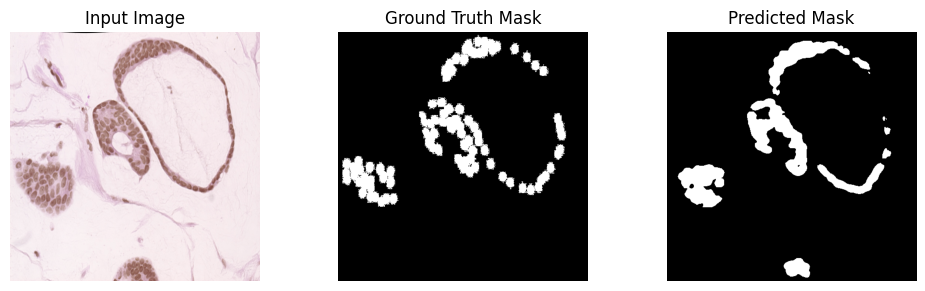

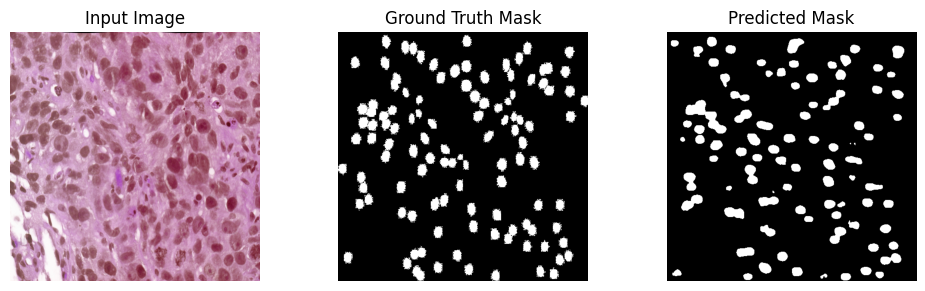

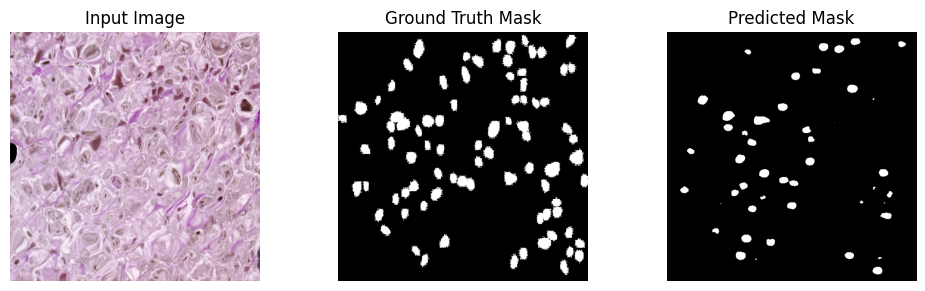

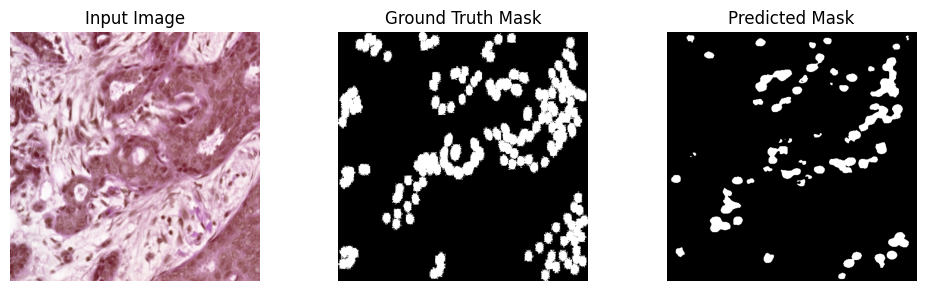

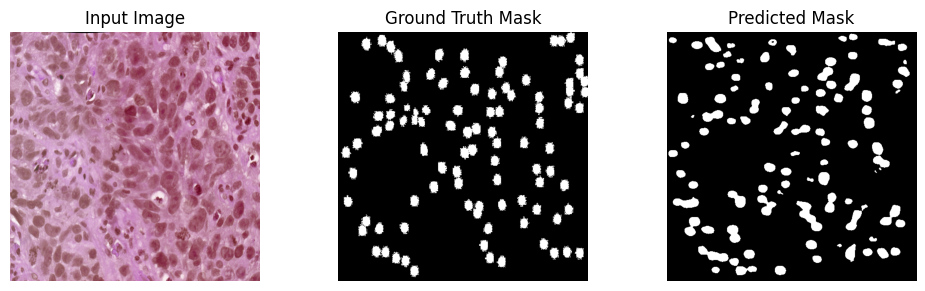

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(test_loader, model, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            images = images.permute(0, 3, 1, 2)

            outputs = model(images)

            preds = torch.sigmoid(outputs)

            preds = (preds > 0.5).float()


            for j in range(min(num_images, len(images))):


                image = images[j].cpu().permute(1, 2, 0).numpy()
                image = (image - image.min()) / (image.max() - image.min())

                mask = masks[j].cpu().squeeze().numpy()
                mask = (mask - mask.min()) / (mask.max() - mask.min())

                pred = preds[j].cpu().squeeze().numpy()
                pred = (pred - pred.min()) / (pred.max() - pred.min())

                plt.figure(figsize=(10, 3))


                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Input Image')
                plt.axis('off')

                # Ground Truth Mask
                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='gray')
                plt.title('Ground Truth Mask')
                plt.axis('off')

                # Predicted Mask
                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap='gray')
                plt.title('Predicted Mask')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            if i >= (num_images // 8):
                break


visualize_predictions(test_loader, model, device)


In [ ]:

images = images.permute(0, 3, 1, 2).to(device)

In [ ]:
import torch

def calculate_dice(output, labels, smooth=1e-6):
    """
    Calculate Dice coefficient for binary segmentation tasks.
    Dice coefficient = 2 * (intersection of pred and label) / (sum of pred and label)
    """
    if labels.shape[-1] == 3:
        labels = labels[:, :, :, 0]

    output = (torch.sigmoid(output) > 0.5).float()
    output = output.squeeze(1)


    intersection = (output.bool() & labels.bool()).float().sum((1, 2))
    union = output.float().sum((1, 2)) + labels.float().sum((1, 2))

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def calculate_accuracy(output, labels):

    if labels.shape[-1] == 3:
        labels = labels[:, :, :, 0]

    # Remove extra channel from output if it exists
    if output.shape[1] == 1:
        output = output.squeeze(1)


    preds = (torch.sigmoid(output) > 0.5).float()


    correct = preds.eq(labels).sum().item()
    total = labels.numel()

    accuracy = correct / total
    return accuracy

def calculate_test_accuracy(test_loader, model, device):
    model.eval()
    correct_pixels = 0
    total_pixels = 0
    dice_score = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):

            images = images.permute(0, 3, 1, 2).to(device)
            labels = labels.to(device)


            outputs = model(images)


            accuracy = calculate_accuracy(outputs, labels)


            dice_coefficient = calculate_dice(outputs, labels)


            correct_pixels += accuracy * labels.numel()
            total_pixels += labels.numel()
            dice_score += dice_coefficient

    avg_accuracy = correct_pixels / total_pixels
    avg_dice = dice_score / len(test_loader)


    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"Average Dice Coefficient: {avg_dice:.4f}")

    return avg_accuracy, avg_dice


In [ ]:

test_accuracy, avg_dice_coefficient = calculate_test_accuracy(test_loader, model, device)


Test Accuracy: 0.8984
Average Dice Coefficient: 0.5645


In [ ]:
import torch
import torchvision.transforms as transforms


# Step 1: Define the model architecture
model = UNet(n_channels=3, n_classes=1)  # Instantiate your model

# Step 2: Load the saved model checkpoint
checkpoint = torch.load('/content/checkpoints/checkpoint_epoch_9_acc_0.9222.pth')
model.load_state_dict(checkpoint['model_state_dict'])  # Load model parameters
model.eval()

<ipython-input-66-69d32ecdd886>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/checkpoints/checkpoint_epoch_9_acc_0.9222.pth')


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment